In [377]:
import os
import sys

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime

import pandas as pd
module_path = os.path.abspath(os.path.join('../transfermarket/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from transfermarket import leagues, players, teams

In [378]:
# for some reason transfr market lists world cup on 2021 page
world_cup_year= "2021"

# get 2022 premier league clubs
prem_clubs_22 = leagues.get_prem_club_list(season="2022")

In [7]:
def get_world_cup_minutes(team_url:str):
    team_22_players = teams.get_players(team_url)
    team_22_players.keys()
    team_22_player_urls = {player:"https://www.transfermarkt.com" + url for player,url in team_22_players.items()}

    team_minutes_played_22 = []

    for player,url in team_22_player_urls.items():
        print("grabbing data for: " + player)
        match_data = players.get_match_data(url,world_cup_year)
        if match_data is None:
            continue
        min_played = players.get_minutes_played(match_data)
        min_played['player_name'] = player
        team_minutes_played_22.append(min_played)

    all_minutes_played= pd.concat(team_minutes_played_22)

    world_cup_start = datetime(2022,11,20)
    world_cup_end = datetime(2022,12,18)

    world_cup_minutes = all_minutes_played.loc[all_minutes_played['Date'].between(world_cup_start, world_cup_end)]

    return world_cup_minutes

In [ ]:
prem_world_cup_minutes = {}
failed_scrape = []

for club,url in prem_clubs_22.items():
    try:
        team_minutes = get_world_cup_minutes(url)
        prem_world_cup_minutes[club] = team_minutes
    except Exception as e:
        print(f"failed for: {club}")
        failed_scrape.append(f"{club}: {e}")
        continue

In [ ]:
for idx, (club, df) in enumerate(prem_world_cup_minutes.items()):
    print(f"{idx} {club}") 
    df["club"] = club

In [12]:
prem_world_cup_minutes_df = pd.concat(prem_world_cup_minutes.values())

In [13]:
prem_world_cup_minutes_df.to_csv("prem_world_cup_22.csv")

Analysis

In [4]:
import pandas as pd
prem_world_cup_minutes_df = pd.read_csv("prem_world_cup_22.csv", index_col=0)
prem_world_cup_minutes_df.groupby('club').sum(numeric_only=True).sort_values('min_played', ascending=False)

,min_played
club,
Manchester City,4630
Tottenham Hotspur,3692
Manchester United,3586
Chelsea FC,3332
Liverpool FC,1789
Arsenal FC,1699
Brighton & Hove Albion,1545
Fulham FC,1333
Aston Villa,1215


In [9]:
team_url = prem_clubs_22['Liverpool FC']
players = teams.get_players(team_url)
player_urls = {player:"https://www.transfermarkt.com" + url for player,url in players.items()}
player_urls

In [19]:
prem_world_cup_minutes_df['player_name'].value_counts()

Lucas Digne            7
Mateo Kovacic          7
Raphaël Varane         7
N'Golo Kanté           7
Hakim Ziyech           7
                      ..
Thomas Partey          3
Tariq Lamptey          3
Wout Faes              3
Armel Bella-Kotchap    3
Philip Billing         3
Name: player_name, Length: 150, dtype: int64

Hacky way to get player's team national team: get mode value of all the teams in the fixtures - we need to concatenate home and away teams first

(saves us from having to make additional requests to transfermarket and trying to scrape it out of the html)

In [43]:
# e.g. for Lucas Digne
teams = prem_world_cup_minutes_df[prem_world_cup_minutes_df['player_name'] =="Lucas Digne"][['Home team.1', 'Away team.1']].values.flatten()
pd.DataFrame(teams).mode()

,0
0,France


In [44]:
player_countries = prem_world_cup_minutes_df.groupby("player_name").apply(lambda df: pd.DataFrame(df[['Home team.1', 'Away team.1']].values.flatten()).mode())

In [57]:
player_countries = player_countries.reset_index().drop("level_1", axis=1).rename({0:'country'}, axis=1)

In [58]:
player_countries.head()

,player_name,country
0,Aaron Ramsdale,England
1,Albert Sambi Lokonga,Belgium
2,Aleksandar Mitrović,Serbia
3,Alexis Mac Allister,Argentina
4,Alisson,Brazil


In [66]:
prem_world_cup_minutes_df = prem_world_cup_minutes_df.merge(player_countries, how='left', left_on="player_name", right_on="player_name")

Text(0, 0.5, '')

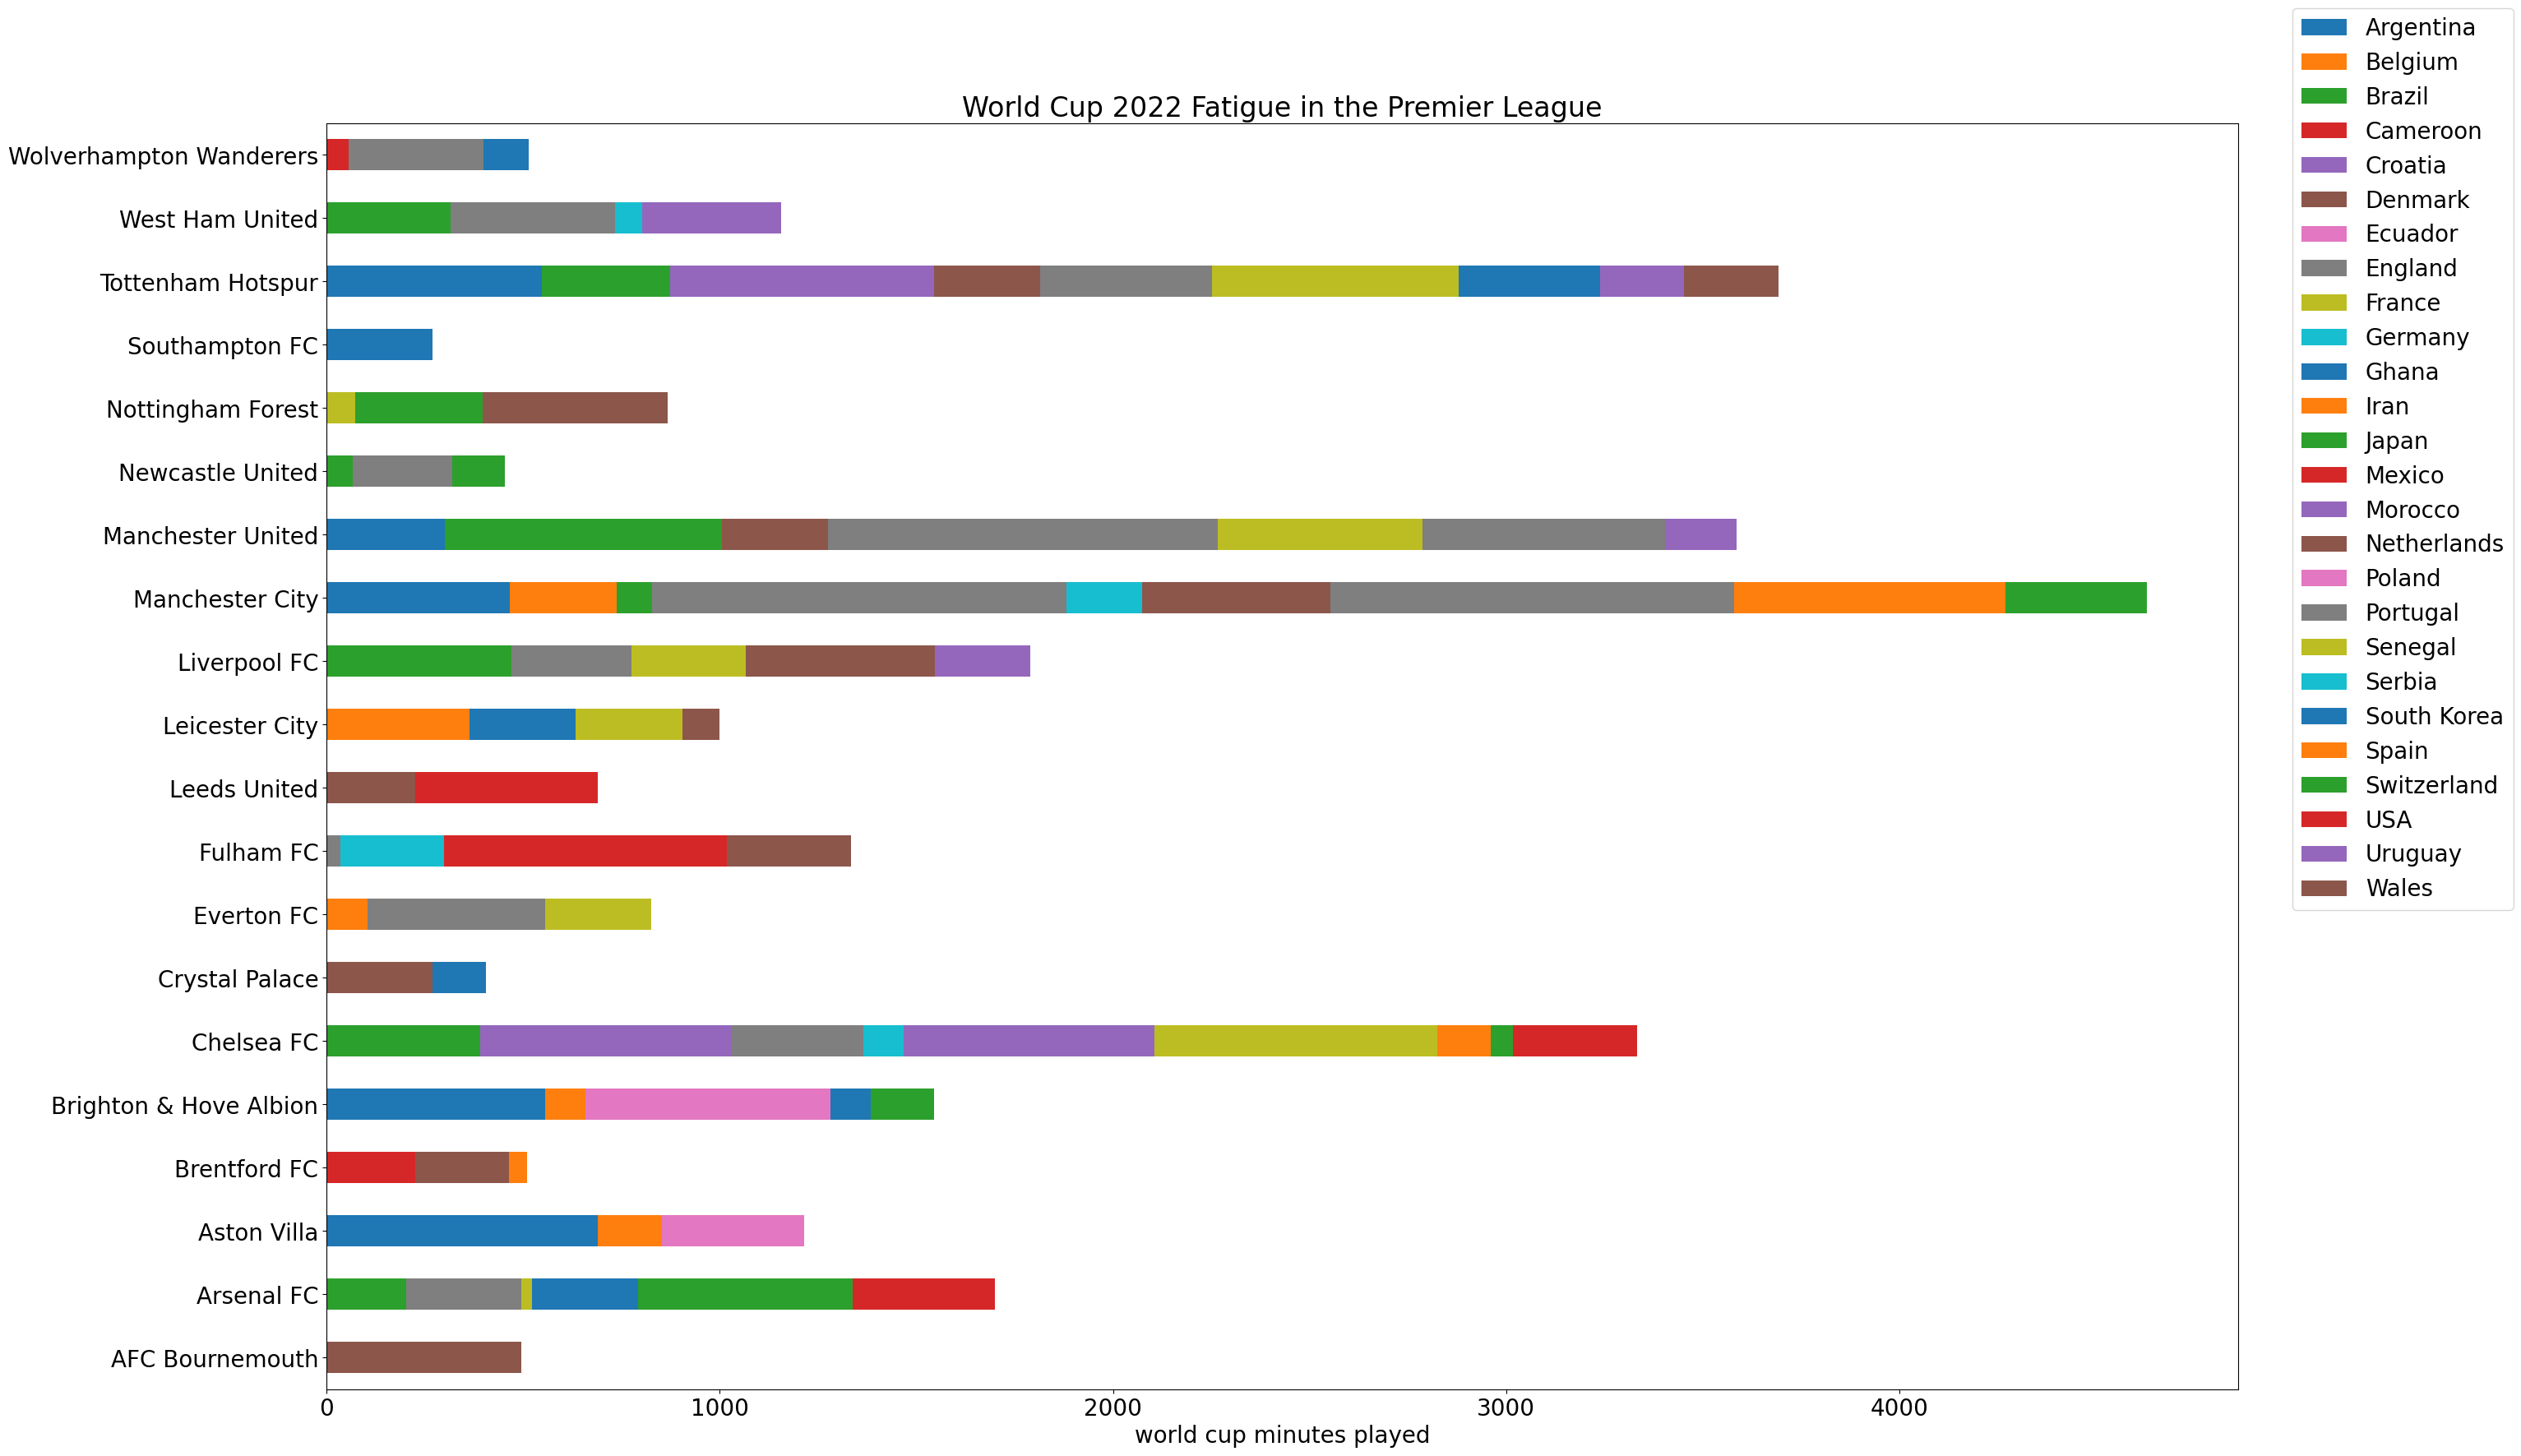

In [159]:
grouped_wc22_minutes =prem_world_cup_minutes_df.groupby(['club', "country"]).sum(numeric_only=True)
df = grouped_wc22_minutes.unstack()
df = df.droplevel(level=0,axis=1)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = '20'

fig, ax = plt.subplots(figsize=(30,20))

df.plot(kind="barh", stacked=True, ax=ax, )

ax.legend(loc='upper right',bbox_to_anchor=(1.15, 1.1) )

ax.set_title("World Cup 2022 Fatigue in the Premier League")
ax.set_xlabel("world cup minutes played")
ax.set_ylabel("")

Too many countries to get anything meaningful (not enough colours to differentiate) 

In [162]:
prem_world_cup_minutes_df['Matchday'] = prem_world_cup_minutes_df['Matchday'].apply(lambda x:  "Group Stage" if 'Group' in x else x)

In [298]:
grouped_wc22_minutes =prem_world_cup_minutes_df.groupby(['club', "Matchday"]).sum(numeric_only=True)
df = grouped_wc22_minutes.unstack()
df = df.droplevel(level=0,axis=1)
# reorder to match tournament order
df = df[['Group Stage','Round of 16', 'Quarter-Finals','Semi-Finals',  'Third Place Play-Off', 'Final'  ]]


In [299]:
prem_standings = pd.read_html("https://www.bbc.co.uk/sport/football/tables")[0]

In [300]:
prem_standings = prem_standings.iloc[:-1, [0,2]].rename({'Unnamed: 0':'prem_position'}, axis=1).set_index('Team')

In [301]:
from fuzzywuzzy import process

In [302]:
# https://stackoverflow.com/a/56315491
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

In [303]:
df = df.reset_index()

In [304]:
prem_standings = prem_standings.reset_index()

In [305]:
merged_standings = fuzzy_merge(df, prem_standings, key1='club', key2='Team', threshold=65, limit=1)

In [306]:
merged_standings.loc[merged_standings['club']=="Manchester United", 'matches'] = 'Man Utd'

In [307]:
merged_standings = merged_standings.merge(prem_standings, how='left', left_on='matches', right_on='Team').drop(['matches', 'Team'], axis=1)

In [308]:
merged_standings['prem_position'] = pd.to_numeric(merged_standings['prem_position'])

In [312]:
merged_standings.sort_values('prem_position', inplace=True, ascending=False)

df = merged_standings.drop("prem_position", axis=1).set_index("club")

In [313]:
merged_standings

,club,Group Stage,Round of 16,Quarter-Finals,Semi-Finals,Third Place Play-Off,Final,prem_position
19,Wolverhampton Wanderers,364.0,99.0,51.0,NaN,NaN,NaN,20
16,Southampton FC,270.0,0.0,0.0,NaN,NaN,NaN,19
15,Nottingham Forest,813.0,54.0,NaN,NaN,NaN,NaN,18
7,Everton FC,645.0,90.0,90.0,NaN,NaN,NaN,17
18,West Ham United,698.0,264.0,195.0,0.0,0.0,0.0,16
9,Leeds United,577.0,113.0,NaN,NaN,NaN,NaN,15
0,AFC Bournemouth,495.0,NaN,NaN,NaN,NaN,NaN,14
10,Leicester City,909.0,90.0,0.0,NaN,NaN,NaN,13
2,Aston Villa,702.0,183.0,120.0,90.0,NaN,120.0,12
6,Crystal Palace,406.0,0.0,0.0,NaN,NaN,NaN,11


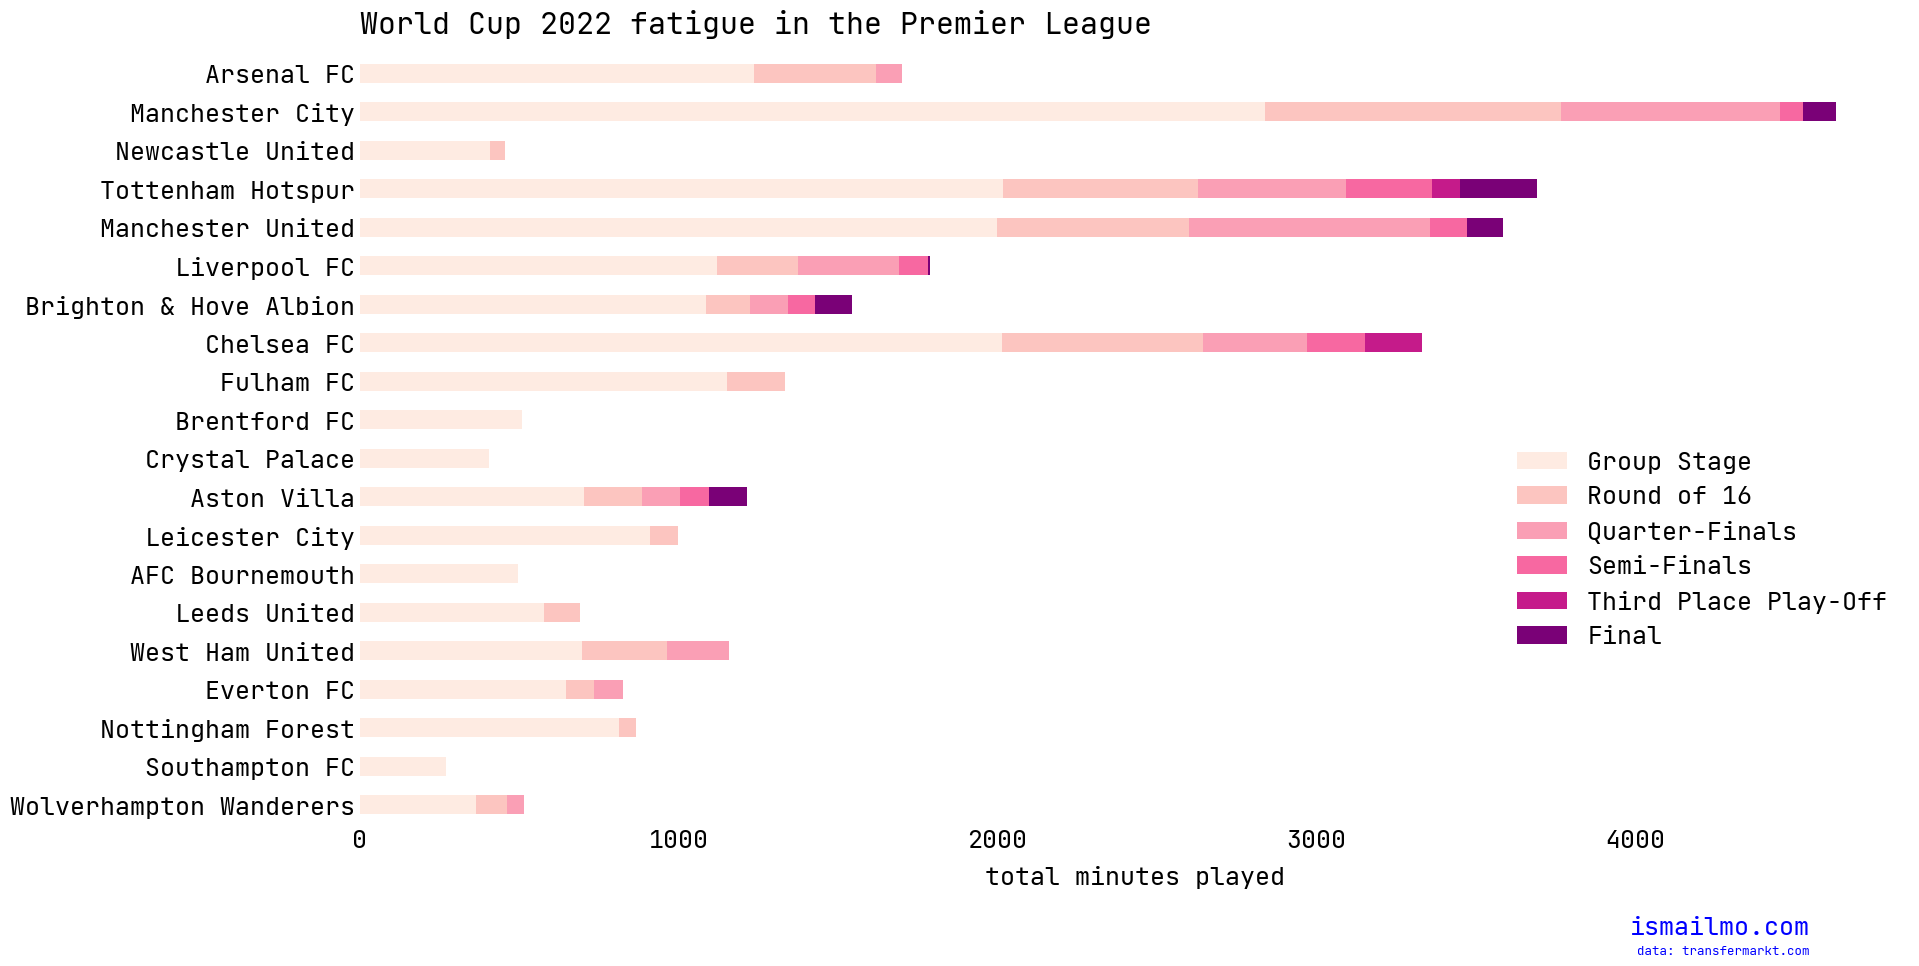

In [423]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'JetBrains Mono'
matplotlib.rcParams['font.size'] = '18'
color_scheme = ['#feebe2','#fcc5c0','#fa9fb5','#f768a1','#c51b8a','#7a0177']

alt_color_scheme = ['#762a83','#af8dc3','#e7d4e8','#d9f0d3','#7fbf7b','#1b7837']
fig, ax = plt.subplots(figsize=(20,10))

df.plot(kind="barh", stacked=True, ax=ax, color=color_scheme)

ax.tick_params(length=0)
ax.set_title("World Cup 2022 fatigue in the Premier League", loc="left", pad=15)
ax.set_xlabel("total minutes played", labelpad=10)
ax.set_ylabel("")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(loc='lower right', bbox_to_anchor = (1, 0.2), frameon=False)

_ = plt.gcf().text(0.85, -0.00, "ismailmo.com", fontsize=18, fontdict={'color':  'blue'}, ha="right")
_ = plt.gcf().text(0.85, -0.02, "data: transfermarkt.com", fontsize=9, fontdict={'color':  'blue'}, ha="right")

In [424]:

fig.savefig('barh_total_plot.svg', transparent=True, bbox_inches='tight')

Total minutes might not tell the full picture, could just be one or two players with a lot of minutes. Does average show a different perspective?

First sum up all minutes for a player - can't do mean at this stage since it'll average per game whereas we want to average over the team - including players that arent in the world cup dataset

In [373]:
player_wc_minutes = prem_world_cup_minutes_df.groupby(["player_name", "club"]).sum()

In [375]:
player_wc_minutes['min_played'].sort_values()

player_name         club                  
Aaron Ramsdale      Arsenal FC                  0
Jannik Vestergaard  Leicester City              0
James Ward-Prowse   Southampton FC              0
N'Golo Kanté        Chelsea FC                  0
Jakub Moder         Brighton & Hove Albion      0
                                             ... 
Hugo Lloris         Tottenham Hotspur         570
Hakim Ziyech        Chelsea FC                638
Mateo Kovacic       Chelsea FC                639
Ivan Perisic        Tottenham Hotspur         671
Emiliano Martínez   Aston Villa               690
Name: min_played, Length: 150, dtype: int64

now add in all the other players from premier league clubs who may not be in this dataset

In [405]:
all_prem_players = { 'player_name':[], 'club':[]}

for team_name, team_url in prem_clubs_22.items():
    player_names = teams.get_players(team_url).keys()
    all_prem_players['club'].extend([team_name]*len(player_names))
    all_prem_players['player_name'].extend(player_names)

/home/ismail/projects/football-data-viz/transfermarket/transfermarket/teams.py:20: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 20 of the file /home/ismail/projects/football-data-viz/transfermarket/transfermarket/teams.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = bs4.BeautifulSoup(team_res.text)
